In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import pulp

In [20]:
curve = [
    "Apr'21", 2.921,
    "May'21", 2.892,
    "Jun'21", 2.922,
    "Jul'21", 2.96,
    "Aug'21", 2.974,
    "Sep'21", 2.966,
    "Oct'21", 3.007,
    "Nov'21", 3.07,
    "Dec'21", 3.203,
    "Jan'22", 3.294,
    "Feb'22", 3.216,
    "Mar'22", 3.03,
    "Apr'22", 2.568,
    "May'22", 2.48,
    "Jun'22", 2.525,
    "Jul'22", 2.562,
    "Aug'22", 2.57,
    "Sep'22", 2.559,
    "Oct'22", 2.592,
    "Nov'22", 2.681,
    "Dec'22", 2.87,
    "Jan'23", 2.987,
    "Feb'23", 2.939,
    "Mar'23", 2.779,
    "Apr'23", 2.388
]

In [21]:
df = pd.DataFrame( data={ 'Contract': curve[0::2], 'Price': curve[1::2]})

Forward curve exhibits strong seasonality

<AxesSubplot:xlabel='Contract'>

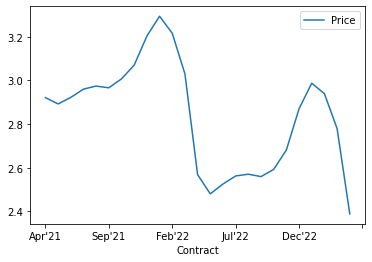

In [22]:
df.plot(x='Contract', y='Price')

Storage contract parameters

In [23]:
N=12 # number of months to use
max_storage_capacity = 100000
max_daily_injection = pd.DataFrame(data=[(0.0,2000),(0.5,2000),(1.1,2000)], columns=['ratchet', 'mdiq'] )
max_daily_withdrawal = pd.DataFrame( data=[(0.0,4000),(0.5,4000),(1.1,4000)], columns=['ratchet', 'mdwq'] )

In [24]:
# injection / withdrawal quantities
I=[None]*N
W=[None]*N
for i in range(N):
    I[i] = pulp.LpVariable(f'I_{i}', lowBound=0, cat='Integer')
    W[i] = pulp.LpVariable(f'W_{i}', lowBound=0, cat='Integer')

In [25]:
# number of days in each injection / drawing month
days = list( map( lambda x: ((x+pd.DateOffset(months=1))-x).days, df.Contract.apply( lambda x: pd.to_datetime( '1-' + x ))))

# number of calendar days in the simulation
K = sum( days[0:N])

prices = list(df.Price)

This is main problem formulation.  It is split by injection and withdrawal operation

In [26]:
injection_charges=[None]*N
total_injection=[None]*N
daily_injection=[None]*K

# for each injection month
for i in range(N):
    total_injection[i] = I[i]*10000
    injection_charges[i] = -total_injection[i] * prices[i]
    
for i in range(N):
    lb = sum(days[0:i])
    ub = sum(days[:i+1])
    daily_injection[lb:ub] = [ total_injection[i] / days[i] ] * days[i]

withdrawal_credit=[None]*N
total_draw=[None]*N
daily_draw=[None]*K

# for each drawing month
for j in range(N):
    total_draw[j] = W[j]*10000
    withdrawal_credit[j] = total_draw[j] * prices[j]
    
for i in range(N):
    lb = sum(days[0:i])
    ub = sum(days[:i+1])
    daily_draw[lb:ub]  = [ total_draw[i] / days[i] ] * days[i]

daily_storage=[None]*K
for i in range(K):
    if i == 0:
        daily_storage[i] = daily_injection[i] - daily_draw[i]
    else:
        daily_storage[i] = daily_injection[i] - daily_draw[i] + daily_storage[i-1]

Here we are defining set of binary variables that will help to partition ratchets

In [27]:
# ratchet range control variables 
irc = [[None] * 2 for _ in range(K-1)]
wrc = [[None] * 2 for _ in range(K-1)]

for i in range(0,K-1):
    for j in range(max_daily_injection.shape[0]-1):
        irc[i][j] = pulp.LpVariable(f'ic_{i+1}_{j}', cat='Binary')

    for j in range(max_daily_withdrawal.shape[0]-1):
        wrc[i][j] = pulp.LpVariable(f'wc_{i+1}_{j}', cat='Binary')

**Build_model** is a function that defines constraints.  The trick here is to use big M technique 

In [28]:
def build_model( max_daily_injection, max_daily_withdrawal):
    m = pulp.LpProblem("WithRatchetsDaily", pulp.LpMaximize)

    # target function
    m += pulp.lpSum(withdrawal_credit) + pulp.lpSum(injection_charges)

    # add constraints
    for i in range(K):
        m += daily_storage[i] >= 0
        m += daily_storage[i] <= max_storage_capacity

    # storage is empty on day 0
    m += daily_injection[0] <= max_daily_injection.loc[0, 'mdiq']
    m += daily_draw[0] <= max_daily_withdrawal.loc[ 0, 'mdwq']

    M1 = -200 # lower boundary for the ratchet range
    M2 = 200  # higher boundary for the ratchet range

    # ratchet control
    for i in range(K-1):

        # injection
        # only one range is allowed
        m += pulp.lpSum( irc[i] ) == 1

        # first range
        m += irc[i][0] * max_daily_injection.loc[0,'ratchet'] + (1 - irc[i][0] ) * M1 \
             <=  daily_storage[i] / max_storage_capacity
        m += irc[i][0] * max_daily_injection.loc[1,'ratchet'] + (1 - irc[i][0] ) * M2 \
             >=  daily_storage[i] / max_storage_capacity

        # second range
        m += irc[i][1] * max_daily_injection.loc[1,'ratchet'] + (1 - irc[i][1] ) * M1 \
             <=  daily_storage[i] / max_storage_capacity
        m += irc[i][1] * max_daily_injection.loc[2,'ratchet'] + (1 - irc[i][1] ) * M2 \
             >=  daily_storage[i] / max_storage_capacity

        # daily rate constraint
        m += daily_injection[i+1] <= irc[i][0] * max_daily_injection.loc[1,'mdiq'] + \
             irc[i][1] * max_daily_injection.loc[2,'mdiq']

        # withdrawal
        # only one range is allowed
        m += pulp.lpSum( wrc[i] ) == 1

        # first range
        m += wrc[i][0] * max_daily_withdrawal.loc[0,'ratchet'] + ( 1 - wrc[i][0] ) * M1 \
             <=  daily_storage[i] / max_storage_capacity
        m += wrc[i][0] * max_daily_withdrawal.loc[1,'ratchet'] + ( 1 - wrc[i][0]) * M2 \
             >= daily_storage[i] / max_storage_capacity

        # second range
        m += wrc[i][1] * max_daily_withdrawal.loc[1,'ratchet'] + ( 1 - wrc[i][1] ) * M1 \
             <=  daily_storage[i] / max_storage_capacity
        m += wrc[i][1] * max_daily_withdrawal.loc[2,'ratchet'] + ( 1 - wrc[i][1]) * M2 \
             >= daily_storage[i] / max_storage_capacity

        # daily rate constraint
        m += daily_draw[i+1] <= wrc[i][0] * max_daily_withdrawal.loc[1,'mdwq'] + \
             wrc[i][1] * max_daily_withdrawal.loc[2,'mdwq']

    # ensure that storage is empty on the last day 
    m += daily_storage[K-1] == 0
    
    return m

Baseline scenario.  Max daily injection quantity is flat at 2000 Dth per day  

In [29]:
m = build_model( max_daily_injection, max_daily_withdrawal )
solver = pulp.getSolver('PULP_CBC_CMD')
m.solve(solver)
pulp.LpStatus[m.status], pulp.value(m.objective) 

('Optimal', 39519.99999999997)

The following cell shows required hedges. For example we need to buy 4 April'2021 contracts and sell 12 Sep'2021 contracts

In [30]:
for variable in m.variables():
    if variable.varValue != 0.0 and variable.name[:2] in ('I_', 'W_'):
        print( "{} = {}".format(variable.name, variable.varValue) )

I_0 = 4.0
I_1 = 6.0
I_10 = 5.0
I_3 = 6.0
I_4 = 6.0
I_5 = 6.0
I_6 = 6.0
I_8 = 6.0
W_10 = 5.0
W_3 = 6.0
W_4 = 12.0
W_6 = 6.0
W_8 = 6.0
W_9 = 10.0


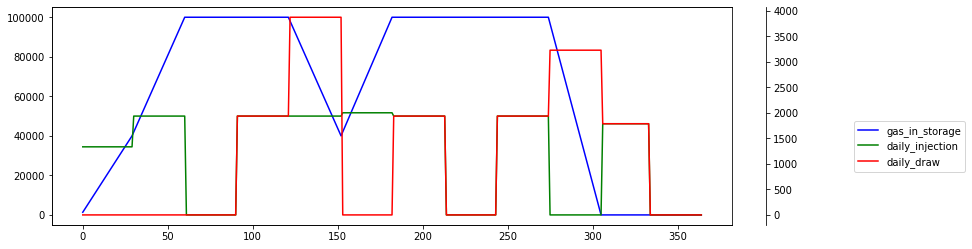

In [31]:
df_result = pd.DataFrame( data={
    'gas_in_storage': map(lambda x: pulp.value(x) , daily_storage),
    'daily_injection': map(lambda x: pulp.value(x), daily_injection),
    'daily_draw': map(lambda x: pulp.value(x), daily_draw),
})

fig, ax = plt.subplots()
ax3 = ax.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.05))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=1.7)

df_result['gas_in_storage'].plot(ax=ax, style='b-')
df_result['daily_injection'].plot(ax=ax3, style='g-')
df_result['daily_draw'].plot(ax=ax3, style='r-')

ax3.legend([ax.get_lines()[0], ax3.get_lines()[0], ax3.get_lines()[1]], ['gas_in_storage','daily_injection', 'daily_draw'], bbox_to_anchor=(1.35, 0.5))

We're going to run simulation when injection ratchet is reduced to 1000 Dth per day at 50% storage level.  Note that profit now is lower by 11% vs flat ratchet scenario

In [32]:
max_daily_injection2 = pd.DataFrame(data=[(0.0,2000),(0.5,2000),(1.1,1000)], columns=['ratchet', 'mdiq'] )
max_daily_withdrawal2 = pd.DataFrame( data=[(0.0,2000),(0.5,2000),(1.1,4000)], columns=['ratchet', 'mdwq'] )

m = build_model( max_daily_injection2, max_daily_withdrawal2 )
solver = pulp.getSolver('PULP_CBC_CMD')
m.solve(solver)
pulp.LpStatus[m.status], pulp.value(m.objective)

('Optimal', 35269.999999999985)

Injection and withdrawal ratchets look like this now

<AxesSubplot:xlabel='ratchet'>

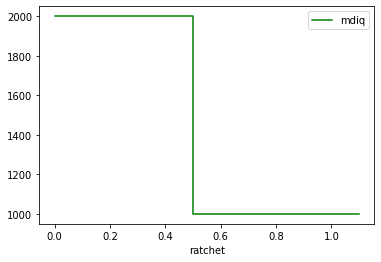

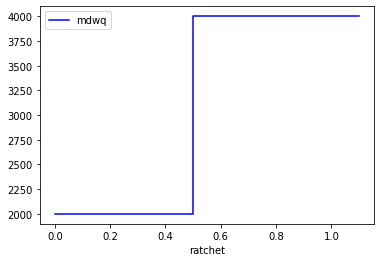

In [33]:
max_daily_injection2.plot(x='ratchet',y='mdiq', style='g-', drawstyle="steps" )
max_daily_withdrawal2.plot(x='ratchet',y='mdwq',style='b-', drawstyle="steps")

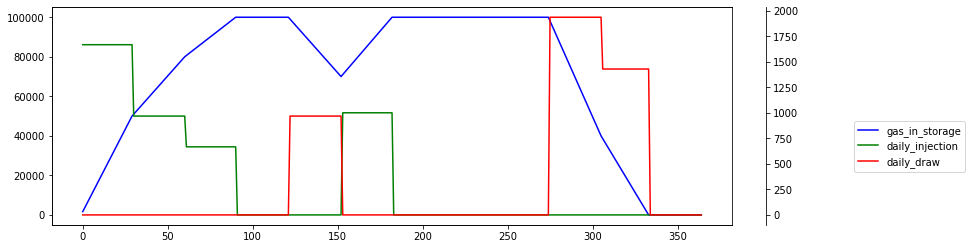

In [34]:
df_result = pd.DataFrame( data={
    'gas_in_storage': map(lambda x: pulp.value(x) , daily_storage),
    'daily_injection': map(lambda x: pulp.value(x), daily_injection),
    'daily_draw': map(lambda x: pulp.value(x), daily_draw),
})

fig, ax = plt.subplots()
ax3 = ax.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.05))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=1.7)

df_result['gas_in_storage'].plot(ax=ax, style='b-')
df_result['daily_injection'].plot(ax=ax3, style='g-')
df_result['daily_draw'].plot(ax=ax3, style='r-')

ax3.legend([ax.get_lines()[0], ax3.get_lines()[0], ax3.get_lines()[1]], ['gas_in_storage','daily_injection', 'daily_draw'], bbox_to_anchor=(1.35, 0.5))

In this experiment we're going to use very steep ratchet. A reduction by 75% of max daily injection rate when storage is above 50% of max storage level.  Such contract is now worth 23% less then flat ratchet scenario

In [35]:
max_daily_injection3 = pd.DataFrame(data=[(0.0,2000),(0.5,2000),(1.1,500)], columns=['ratchet', 'mdiq'] )
max_daily_withdrawal3 = pd.DataFrame( data=[(0.0,1000),(0.5,1000),(1.1,4000)], columns=['ratchet', 'mdwq'] )
m = build_model( max_daily_injection3, max_daily_withdrawal3 )
solver = pulp.getSolver('PULP_CBC_CMD')
m.solve(solver)
pulp.LpStatus[m.status], pulp.value(m.objective)

('Optimal', 30400.000000000015)

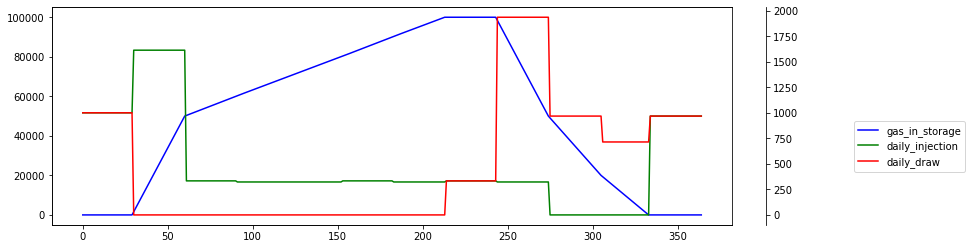

In [36]:
df_result = pd.DataFrame( data={
    'gas_in_storage': map(lambda x: pulp.value(x) , daily_storage),
    'daily_injection': map(lambda x: pulp.value(x), daily_injection),
    'daily_draw': map(lambda x: pulp.value(x), daily_draw),
})

fig, ax = plt.subplots()
ax3 = ax.twinx()
rspine = ax3.spines['right']
rspine.set_position(('axes', 1.05))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
fig.subplots_adjust(right=1.7)

df_result['gas_in_storage'].plot(ax=ax, style='b-')
df_result['daily_injection'].plot(ax=ax3, style='g-')
df_result['daily_draw'].plot(ax=ax3, style='r-')

ax3.legend([ax.get_lines()[0], ax3.get_lines()[0], ax3.get_lines()[1]], ['gas_in_storage','daily_injection', 'daily_draw'], bbox_to_anchor=(1.35, 0.5))